# PAMAP2 - SE-GoogLeNet-BiGRU
1. 전처리 개선
- Butterworth filtering으로 20Hz 이상의 신호들을 cut
- Jittering, Scaling, Permutation, Time Warping의 기법을 이용하여 데이터 증강 -> 데이터를 왜곡하고 변형시켜서 다양한 경우를 학습하게끔 함 -> 비율은 0.2

2. feature 축소
- 27개의 feature만 사용 (hand, chest, ankle의 acc_16g, mag, gyro -> 3축씩이므로 27개)
3. SE + GoogLeNet(Residual Connection) + BiGRU

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from torchsummary import summary
from sklearn.manifold import TSNE
import math
from scipy.signal import butter, filtfilt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        ys.append(stats.mode(labels, keepdims=True)[0][0])
        Xs.append(x)
    return np.array(Xs), np.array(ys).reshape(-1, 1)

def prepare_data_split(df, time_steps, steps, activity_mapping):
    X = df.drop(columns=['activityID', 'subject'])
    y = df['activityID'].map(activity_mapping)
    X_seq, y_seq = create_dataset(X, y, time_steps, steps)
    return X_seq, y_seq.flatten()

In [ ]:
def jitter(x, sigma=0.03):
    """랜덤 노이즈 추가"""
    noise = np.random.normal(loc=0, scale=sigma, size=x.shape)
    return x + noise

def scaling(x, sigma=0.1):
    """랜덤 스케일 변환"""
    factor = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[1],))
    return x * factor

def permutation(x, max_segments=5):
    """시계열 구간을 나눠 순서를 섞음"""
    orig_steps = np.arange(x.shape[0])
    num_segs = np.random.randint(1, max_segments)
    split_points = np.random.choice(x.shape[0], num_segs, replace=False)
    split_points.sort()
    segments = np.split(orig_steps, split_points)
    np.random.shuffle(segments)
    permuted_idx = np.concatenate(segments)
    return x[permuted_idx]

def time_warp(x, sigma=0.2):
    """시간축 왜곡"""
    from scipy.interpolate import CubicSpline
    time_steps = np.arange(x.shape[0])
    random_curve = np.random.normal(loc=1.0, scale=sigma, size=(4,))
    warp_steps = np.linspace(0, x.shape[0]-1, num=4)
    cs = CubicSpline(warp_steps, random_curve)
    warp = cs(time_steps)
    warp = (warp - warp.min()) / (warp.max() - warp.min()) * (x.shape[0]-1)
    warped_x = np.zeros_like(x)
    for i in range(x.shape[1]):
        warped_x[:, i] = np.interp(time_steps, warp, x[:, i])
    return warped_x

In [ ]:
class PAMAP2Dataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.y[idx]
        if self.augment:
            x_np = x.numpy()
            # 무작위로 증강 적용
            if np.random.rand() < 0.2:
                x_np = jitter(x_np, sigma=0.03)
            if np.random.rand() < 0.2:
                x_np = scaling(x_np, sigma=0.1)
            if np.random.rand() < 0.2:
                x_np = permutation(x_np)
            if np.random.rand() < 0.2:
                x_np = time_warp(x_np)
            x = torch.FloatTensor(x_np)
        return x, y

In [ ]:
class SEBlock1D(nn.Module):
    """ 1D 데이터(시계열)를 위한 Squeeze-and-Excitation (SE) 블록 """
    def __init__(self, channels, reduction_ratio=16):
        """
        Args:
            channels (int): 입력 특징 맵의 채널 수 (C)
            reduction_ratio (int): Excitation 단계의 병목 구조에서 차원을 얼마나 줄일지에 대한 비율 (r)
        """
        super(SEBlock1D, self).__init__()

        # Squeeze: 입력 (B, C, L) -> 출력 (B, C, 1)
        self.gap = nn.AdaptiveAvgPool1d(1)

        # Excitation
        self.fc_stack = nn.Sequential(
            # FC 1: 채널 차원을 C -> C/r 로 압축 (병목). 1x1 Conv 사용
            nn.Conv1d(channels, channels // reduction_ratio, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            # FC 2: 채널 차원을 C/r -> C 로 다시 복원
            nn.Conv1d(channels // reduction_ratio, channels, kernel_size=1, bias=False),
            # Sigmoid: 0~1 사이의 값으로 채널별 중요도 가중치를 생성
            nn.Sigmoid()
        )

    def forward(self, x):
        # x shape: (B, C, L)

        # Squeeze
        x_squeeze = self.gap(x)  # shape: (B, C, 1)

        # Excitation
        excitation = self.fc_stack(x_squeeze) # shape: (B, C, 1) (채널별 가중치)

        # 3. Rescale (재조정)
        # 원본 입력 x (B, C, L)에 가중치 excitation (B, C, 1)을 채널별로 곱함
        # (B, C, 1)이 (B, C, L)로 브로드캐스팅되어 적용됨
        return x * excitation

### Inception Module
- 1x1 conv를 사용하여 3x3, 5x5 conv를 사용하기 전에 입력 채널의 수를 줄임 -> 파라미터, 계산량 감소
-  1x1, 3x3, 5x5 컨볼루션과 3x3 Max Pooling을 병렬적으로 동시에 적용한 뒤, 그 결과들을 채널 방향으로 모두 합침 -> 다양한 스케일의 특징 추출
- 각 스케일의 출력 채널 수는 달라도 상관 없음, 대신 concat하기 위해 나머지 차원의 크기는 동일해야 함
- 최적의 채널 수는 하이퍼파라미터

In [ ]:
class InceptionModule1D(nn.Module):
    def __init__(self, in_channels, n1x1, n3x3_reduce, n3x3, n5x5_reduce, n5x5, pool_proj):
        super(InceptionModule1D, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv1d(in_channels, n1x1, kernel_size=1),
            nn.BatchNorm1d(n1x1),
            nn.ReLU(inplace=True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv1d(in_channels, n3x3_reduce, kernel_size=1),
            nn.BatchNorm1d(n3x3_reduce),
            nn.ReLU(inplace=True),
            nn.Conv1d(n3x3_reduce, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm1d(n3x3),
            nn.ReLU(inplace=True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv1d(in_channels, n5x5_reduce, kernel_size=1),
            nn.BatchNorm1d(n5x5_reduce),
            nn.ReLU(inplace=True),
            nn.Conv1d(n5x5_reduce, n5x5, kernel_size=5, padding=2),
            nn.BatchNorm1d(n5x5),
            nn.ReLU(inplace=True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
            nn.Conv1d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm1d(pool_proj),
            nn.ReLU(inplace=True),
        )

        out_channels = n1x1 + n3x3 + n5x5 + pool_proj
        self.se = SEBlock1D(out_channels)

        # Shortcut 경로 (Residual 연결)
        # 입력을 동일한 차원으로 맞춰주기 위한 1x1 Conv (프로젝션)가 필요함
        if in_channels != out_channels:
            self.shortcut = nn.Conv1d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity() # 입력을 그대로 반환 (그냥 통과)

    def forward(self, x):
        # Concatenate outputs of all four branches
        out = torch.cat([self.b1(x), self.b2(x), self.b3(x), self.b4(x)], 1)
        out = self.se(out)
        return out + self.shortcut(x)

### GoogLeNetHAR
1. Stem Network: conv/pooling layer -> 입력 데이터의 크기를 줄이고 기본적인 특징 추출
2. Inception 블록 스택
3. Global Average Pooling & Classifier

채널 수 설정 기준
- original GooLeNet의 채널 비율
- 3x3: 가장 핵심적 특징 추출기 -> 가장 많은 출력 채널 할당
- 1x1: 가장 지역적인 특징 -> 그 다음으로 할당
- 5x5: 계산 비용 높음 -> 병목을 통해 채널을 줄인 뒤 적은 수의 채널만 출력
- Max Pooling: 기존 특징을 요약 -> 적은 수의 채널 할당

nn.GRU
- input_size: 입력 feature 크기 (벡터의 크기)
- hidden_size: 은닉 상태 벡터의 크기, 즉 마지막 시점의 은닉 상태 = GRU의 출력 feature
- bidirectional=True: bidirectional GRU가 됨

In [ ]:
class GoogLeNetHAR(nn.Module):
    def __init__(self, num_classes, input_channels):
        super(GoogLeNetHAR, self).__init__()

        # Stem
        self.stem = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )

        # Inception modules
        self.inception3a = InceptionModule1D(64, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule1D(256, 128, 128, 192, 32, 96, 64)
        self.maxpool1 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.inception4a = InceptionModule1D(480, 192, 96, 208, 16, 48, 64)

        self.gru = nn.GRU(512, 256, num_layers=2, bidirectional=True, batch_first=True)

        # Classifier
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool1(x)
        x = self.inception4a(x)
        x = x.permute(0, 2, 1)
        x, _ = self.gru(x)
        x = x.permute(0, 2, 1)
        x = self.global_pool(x)
        x = x.flatten(1) # linear 레이어에 전달하기 전 flatten
        x = self.dropout(x)
        x = self.classifier(x)
        return x

    def get_features(self, x):
        x = self.stem(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool1(x)
        x = self.inception4a(x)
        x = x.permute(0, 2, 1)
        x, _ = self.gru(x)
        x = x.permute(0, 2, 1)
        x = self.global_pool(x)
        return x.flatten(1)

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        data = data.permute(0, 2, 1)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            data = data.permute(0, 2, 1)
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

Nyquist frequency
- 디지털 신호 처리에서 나타낼 수 있는 최대 주파수 = 샘플링 주파수의 절반
- 더 높은 주파수는 aliasing(겹침 현상) 때문에 엉뚱하게 보이게 됨
- PAMAP2의 경우 샘플링 주파수 100Hz의 절반인 50Hz까지 표현 가능

zero-phase filtering
- 위상 지연 없는 필터링
- 보통 필터를 적용하면 신호가 뒤로 밀림 -> 문제!
- scipy.signal.filtfilt 함수는 양방향 필터링을 사용
- 신호를 앞으로 한 번 필터링하고 뒤집어서 다시 필터링 -> 지연이 상쇄되어 위상 지연 없는 결과를 얻게 됨

butter()
- order: 몇차 필터인지
- btype='low': low-pass 필터(저주파수만 통과)


In [ ]:
def butter_lowpass_filter(data, cutoff=20, fs=100, order=3):
    """
    Butterworth Low-pass Filter
    data : numpy array (shape: [n_samples, n_features])
    cutoff : 차단 주파수 (Hz)
    fs : 샘플링 주파수 (Hz) (PAMAP2는 100Hz)
    order : 필터 차수
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist # butter 함수는 cutoff를 0과 1 사이로 받음 -> 정규화
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data, axis=0)  # zero-phase filtering
    return y

In [ ]:
# Start the main LOSO logic
# Load data
df = pd.read_csv('/content/drive/MyDrive/AI_data/PAMAP2/PAMAP2_integrated_data.csv')

df = df.drop(columns=['timestamp', 'heart_rate', 'hand_temp', 'hand_acc_6g_x', 'hand_acc_6g_y', 'hand_acc_6g_z', 'hand_orient_1', 'hand_orient_2', 'hand_orient_3', 'hand_orient_4',
                 'chest_temp', 'chest_acc_6g_x', 'chest_acc_6g_y', 'chest_acc_6g_z', 'chest_orient_1', 'chest_orient_2', 'chest_orient_3', 'chest_orient_4', 'ankle_temp', 'ankle_acc_6g_x', 'ankle_acc_6g_y', 'ankle_acc_6g_z',
                 'ankle_orient_1', 'ankle_orient_2', 'ankle_orient_3', 'ankle_orient_4'])

# Handle NaN values and map activities
activity_mapping = {
    1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6,
    12: 7, 13: 8, 16: 9, 17: 10, 24: 11
}
df = df[df['activityID'].isin(activity_mapping.keys())]

df_list = []
for activity_id in df['activityID'].unique():
    activity_df = df[df['activityID'] == activity_id].copy()
    activity_df[activity_df.select_dtypes(exclude='object').columns] = (
        activity_df.select_dtypes(exclude='object').interpolate(method='linear')
    )
    activity_df = activity_df.ffill().bfill()
    df_list.append(activity_df)

df_processed = pd.concat(df_list, ignore_index=True)

# Apply Butterworth low-pass filter
features_to_filter = df_processed.columns.drop(['subject', 'activityID'])
df_processed[features_to_filter] = butter_lowpass_filter(
    df_processed[features_to_filter].values,
    cutoff=20, fs=100, order=3
)

df_processed.head()

,activityID,hand_acc_16g_x,hand_acc_16g_y,hand_acc_16g_z,hand_gyro_x,hand_gyro_y,hand_gyro_z,hand_mag_x,hand_mag_y,hand_mag_z,...,ankle_acc_16g_x,ankle_acc_16g_y,ankle_acc_16g_z,ankle_gyro_x,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z,subject
0,1.0,2.215311,8.279185,5.587492,-0.004688,0.037574,-0.011143,8.932151,-67.932570,-19.975950,...,9.738587,-1.847620,0.095187,0.002924,-0.027712,0.001757,-61.108071,-36.863658,-58.369482,Protocol_subject101
1,1.0,2.270692,7.656998,5.708145,-0.158689,0.025623,-0.004949,9.324159,-67.796862,-20.213994,...,9.704658,-1.879275,0.016321,-0.008734,-0.024210,0.004110,-60.778333,-36.321051,-58.462907,Protocol_subject101
2,1.0,2.279983,7.238335,5.835367,-0.232334,0.013881,0.000158,9.527461,-67.598849,-20.274849,...,9.694099,-1.892449,0.004850,-0.019546,-0.026877,0.007027,-60.517133,-36.280077,-58.350839,Protocol_subject101
3,1.0,2.246897,7.099966,5.960158,-0.194202,0.004888,0.004378,9.444523,-67.332909,-20.161809,...,9.702474,-1.890282,0.032365,-0.020971,-0.033965,0.008265,-60.436305,-36.691576,-58.047151,Protocol_subject101
4,1.0,2.222287,7.179726,6.037726,-0.073501,0.002142,0.011700,9.175126,-67.070007,-20.021627,...,9.702895,-1.885303,0.021492,-0.008781,-0.039011,0.005822,-60.640978,-37.056016,-57.802956,Protocol_subject101


In [ ]:
# Define constants
TIME_STEPS = 100
STEPS = 50
num_epochs = 100
patience = 20

# LOSO Subjects
loso_test_subjects = ['Protocol_subject101', 'Protocol_subject102', 'Protocol_subject105', 'Protocol_subject106', 'Protocol_subject108']
all_subjects = df_processed['subject'].unique().tolist()

# Lists to store results across all folds
all_preds = []
all_labels = []
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
all_X_test = []

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# LOSO Loop
for fold_idx, test_subject in enumerate(loso_test_subjects):
    print(f"--- Starting LOSO Fold {fold_idx + 1}/{len(loso_test_subjects)}: Test Subject: {test_subject} ---")

    # Set up training, validation, and test sets for the current fold
    if test_subject == 'Protocol_subject105':
        val_subject = 'Protocol_subject106'
    else:
        val_subject = 'Protocol_subject105'

    train_subjects = [s for s in all_subjects if s not in [test_subject, val_subject]]

    train_df = df_processed[df_processed['subject'].isin(train_subjects)].copy()
    val_df = df_processed[df_processed['subject'] == val_subject].copy()
    test_df = df_processed[df_processed['subject'] == test_subject].copy()

    # Scale data
    features_to_scale = df_processed.columns.drop(['subject', 'activityID'])
    scaler = MinMaxScaler()
    train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])
    val_df[features_to_scale] = scaler.transform(val_df[features_to_scale])
    test_df[features_to_scale] = scaler.transform(test_df[features_to_scale])

    # Prepare data for PyTorch
    X_train, y_train = prepare_data_split(train_df, TIME_STEPS, STEPS, activity_mapping)
    X_val, y_val = prepare_data_split(val_df, TIME_STEPS, STEPS, activity_mapping)
    X_test, y_test = prepare_data_split(test_df, TIME_STEPS, STEPS, activity_mapping)
    all_X_test.append(X_test)

    train_dataset = PAMAP2Dataset(X_train, y_train, augment=True)   # 훈련 데이터만 증강
    val_dataset   = PAMAP2Dataset(X_val, y_val, augment=False)
    test_dataset  = PAMAP2Dataset(X_test, y_test, augment=False)

    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Re-initialize model, criterion, and optimizer for each fold
    input_features = X_train.shape[2]
    num_classes = len(np.unique(y_train))
    model = GoogLeNetHAR(num_classes, input_features).to(device)

     # Print summary for the first fold only
    if fold_idx == 0:
        print("\n--- Model Summary (Fold 1) ---")
        summary(model, (input_features, TIME_STEPS))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, min_lr=1e-5)

    best_val_loss = float('inf')
    patience_counter = 0

    fold_train_losses, fold_val_losses = [], []
    fold_train_accuracies, fold_val_accuracies = [], []

    # Training loop
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        fold_train_losses.append(train_loss)
        fold_val_losses.append(val_loss)
        fold_train_accuracies.append(train_acc)
        fold_val_accuracies.append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'PAMAP2_GoogLeNet_best_fold_{fold_idx}.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered for fold {fold_idx+1} after {epoch+1} epochs')
                break

    all_train_losses.append(fold_train_losses)
    all_val_losses.append(fold_val_losses)
    all_train_accuracies.append(fold_train_accuracies)
    all_val_accuracies.append(fold_val_accuracies)

    # Evaluation on the test set
    model.load_state_dict(torch.load(f'PAMAP2_GoogLeNet_best_fold_{fold_idx}.pth'))
    model.eval()
    fold_preds = []
    fold_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.permute(0, 2, 1)
            output = model(data)
            _, predicted = torch.max(output, 1)
            fold_preds.extend(predicted.cpu().numpy())
            fold_labels.extend(target.cpu().numpy())

    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

print("\nTraining completed!")

Using device: cuda
--- Starting LOSO Fold 1/5: Test Subject: Protocol_subject101 ---

--- Model Summary (Fold 1) ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 50]          12,096
       BatchNorm1d-2               [-1, 64, 50]             128
              ReLU-3               [-1, 64, 50]               0
         MaxPool1d-4               [-1, 64, 25]               0
            Conv1d-5               [-1, 64, 25]           4,160
       BatchNorm1d-6               [-1, 64, 25]             128
              ReLU-7               [-1, 64, 25]               0
            Conv1d-8               [-1, 96, 25]           6,240
       BatchNorm1d-9               [-1, 96, 25]             192
             ReLU-10               [-1, 96, 25]               0
           Conv1d-11              [-1, 128, 25]          36,992
      BatchNorm1d-12              [-1, 128, 25]   

In [ ]:
# 마지막 폴드에서 저장한 모델 로드
last_fold_idx = len(loso_test_subjects) - 1
model.load_state_dict(torch.load(f'PAMAP2_GoogLeNet_best_fold_{last_fold_idx}.pth'))

# 마지막 폴드의 train_loader를 사용하여 훈련 데이터에 대한 성능을 측정
train_loss, train_acc = validate_epoch(model, train_loader, criterion, device)
print(f"Training accuracy: {train_acc:.2f}%")
print(f"Training loss: {train_loss:.4f}")

# 마지막 폴드의 test_loader를 사용하여 테스트 데이터에 대한 성능을 측정
test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)
print(f"Test accuracy: {test_acc:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 92.01%
Training loss: 0.2519
Test accuracy: 47.53%
Test loss: 2.5339


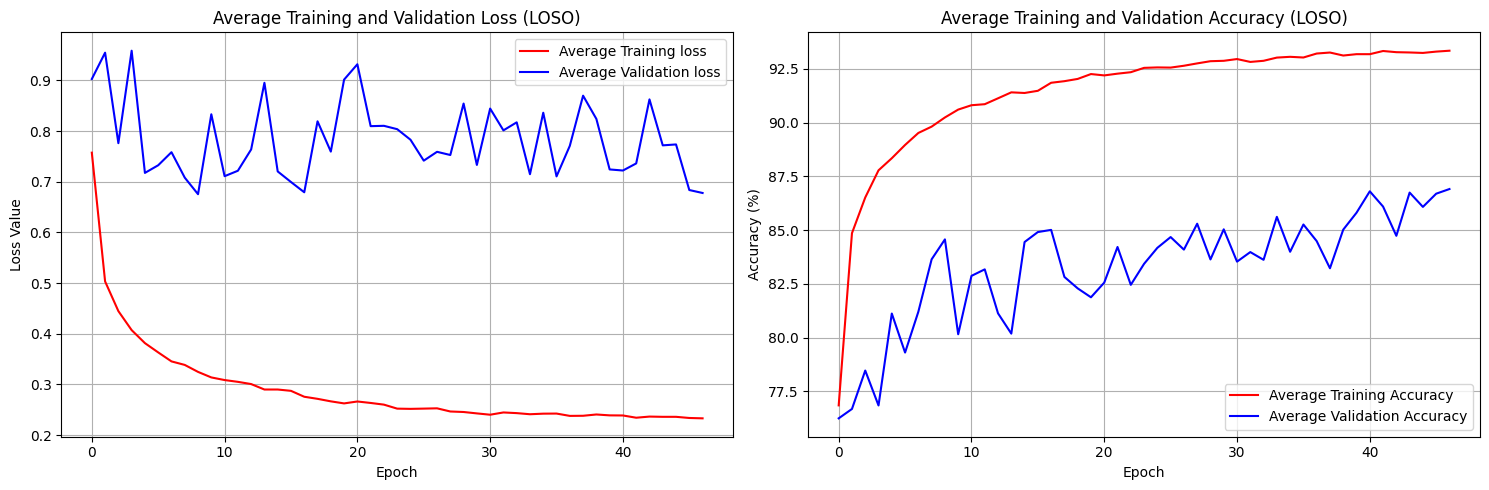

In [ ]:
# Aggregate and Visualize Final Results
max_len = max(len(l) for l in all_train_losses)
padded_train_losses = np.array([l + [l[-1]] * (max_len - len(l)) for l in all_train_losses])
padded_val_losses = np.array([l + [l[-1]] * (max_len - len(l)) for l in all_val_losses])
padded_train_accuracies = np.array([l + [l[-1]] * (max_len - len(l)) for l in all_train_accuracies])
padded_val_accuracies = np.array([l + [l[-1]] * (max_len - len(l)) for l in all_val_accuracies])

avg_train_loss = np.mean(padded_train_losses, axis=0)
avg_val_loss = np.mean(padded_val_losses, axis=0)
avg_train_acc = np.mean(padded_train_accuracies, axis=0)
avg_val_acc = np.mean(padded_val_accuracies, axis=0)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(avg_train_loss, 'r', label='Average Training loss')
plt.plot(avg_val_loss, 'b', label='Average Validation loss')
plt.title('Average Training and Validation Loss (LOSO)')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(avg_train_acc, 'r', label='Average Training Accuracy')
plt.plot(avg_val_acc, 'b', label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy (LOSO)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


--- Final Classification Report (Aggregated LOSO) ---
                   precision    recall  f1-score   support

            lying     0.9658    0.9063    0.9351      2433
          sitting     0.8164    0.7418    0.7773      2374
         standing     0.6942    0.2511    0.3687      2378
          walking     0.8267    0.8244    0.8256      2882
          running     0.9064    0.7332    0.8107      1889
          cycling     0.8120    0.8730    0.8414      2385
   Nordic walking     0.9114    0.6950    0.7886      2636
 ascending stairs     0.4990    0.6995    0.5825      1451
descending stairs     0.3940    0.7072    0.5060      1274
  vacuum cleaning     0.4290    0.7951    0.5573      2269
          ironing     0.8286    0.6960    0.7565      3125
     rope jumping     0.7385    0.4526    0.5613       855

         accuracy                         0.7137     25951
        macro avg     0.7352    0.6979    0.6926     25951
     weighted avg     0.7627    0.7137    0.7164     25951

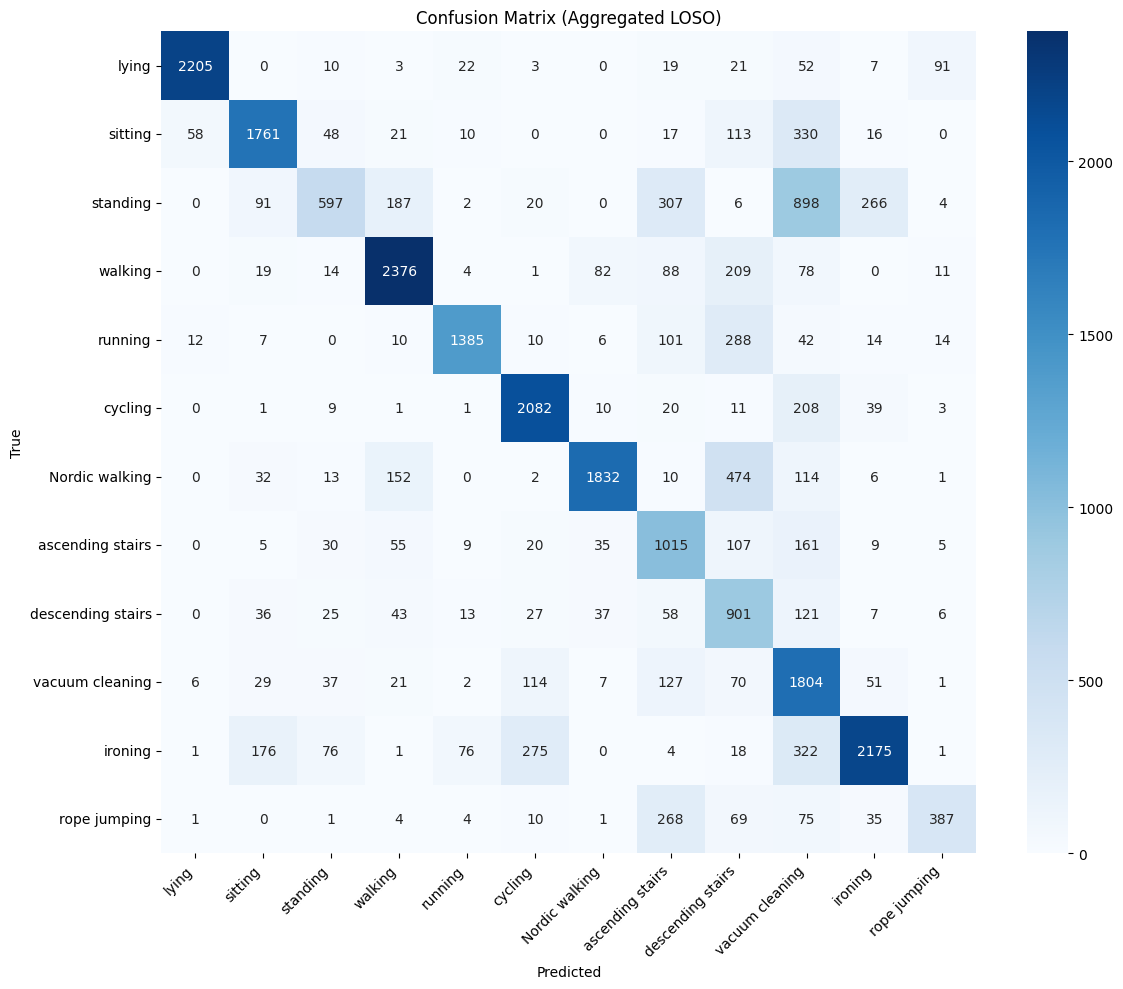

In [ ]:
# Final Classification Report and Confusion Matrix
print("\n--- Final Classification Report (Aggregated LOSO) ---")
LABELS = ['lying', 'sitting', 'standing', 'walking', 'running', 'cycling',
          'Nordic walking', 'ascending stairs', 'descending stairs',
          'vacuum cleaning', 'ironing', 'rope jumping']
target_names = [LABELS[i] for i in np.unique(all_labels)]
print(classification_report(all_labels, all_preds, digits=4, target_names=target_names))

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Aggregated LOSO)')
plt.gca().set_xticklabels(target_names, rotation=45, ha='right')
plt.gca().set_yticklabels(target_names, rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# T-SNE Visualization
# 모든 테스트 데이터와 라벨을 합침
X_test_aggregated = np.concatenate(all_X_test, axis=0)
y_test_aggregated = np.array(all_labels)

# t-SNE는 계산량이 많으므로 일부 샘플만 사용
np.random.seed(42)
num_samples = 5000
if len(X_test_aggregated) > num_samples:
    indices = np.random.choice(len(X_test_aggregated), num_samples, replace=False)
    X_tsne = X_test_aggregated[indices]
    y_tsne = y_test_aggregated[indices]
else:
    X_tsne = X_test_aggregated
    y_tsne = y_test_aggregated

Running t-SNE on raw data...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.010s...
[t-SNE] Computed neighbors for 5000 samples in 3.071s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.239851
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.150192
[t-SNE] KL divergence after 300 iterations: 2.086632


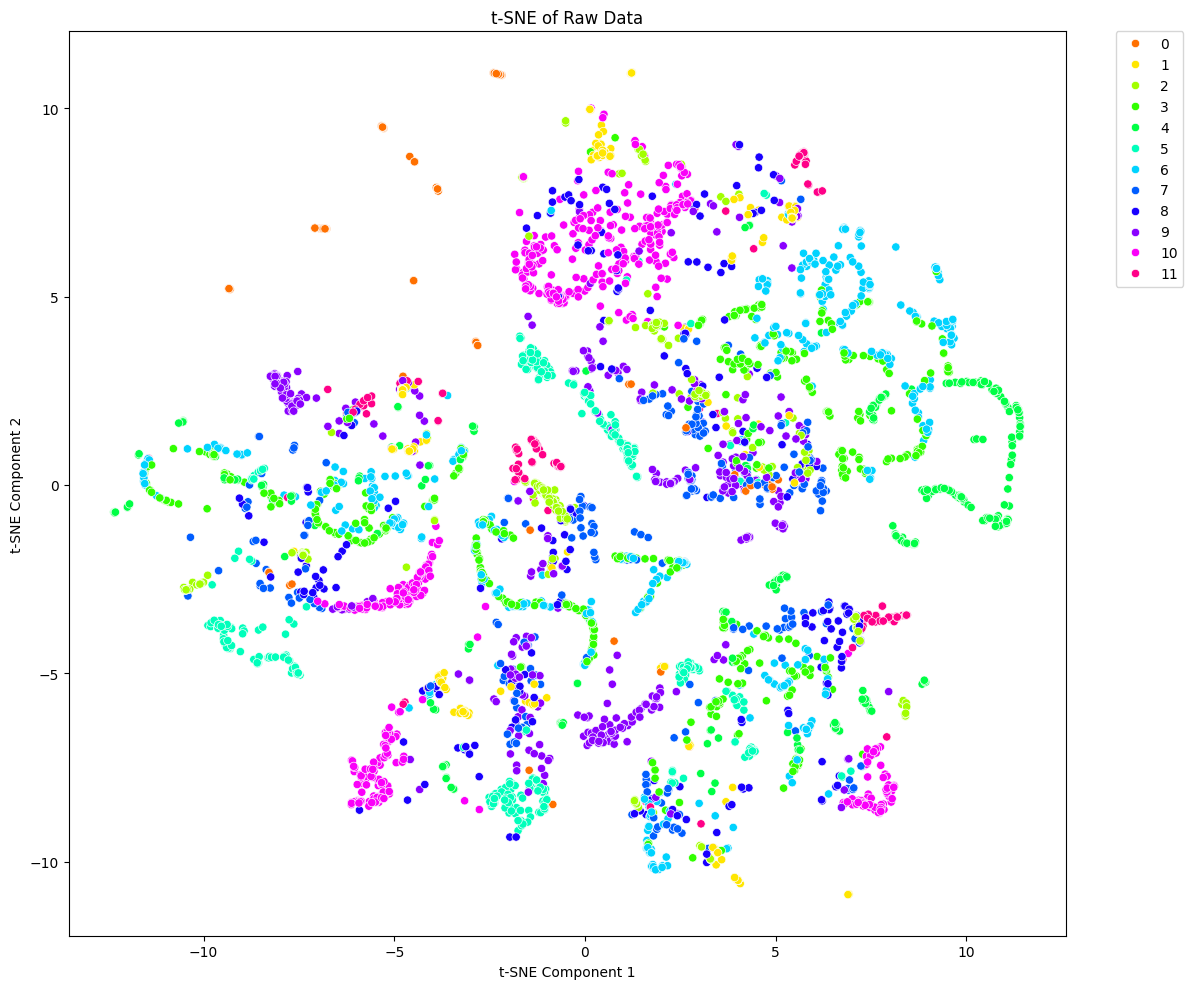

In [ ]:
# 1. 모델 적용 전 (원시 데이터) t-SNE
print("Running t-SNE on raw data...")
X_tsne_flat = X_tsne.reshape(X_tsne.shape[0], -1)
scaler = StandardScaler()
X_tsne_scaled = scaler.fit_transform(X_tsne_flat)

tsne_raw = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300).fit_transform(X_tsne_scaled)

plt.figure(figsize=(12, 10))
sns.scatterplot(x=tsne_raw[:, 0], y=tsne_raw[:, 1], hue=y_tsne, palette=sns.color_palette("hsv", len(LABELS)), legend='full')
plt.title('t-SNE of Raw Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

Running t-SNE on model features...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 5000 samples in 0.794s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.490609
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.378250
[t-SNE] KL divergence after 300 iterations: 1.765524


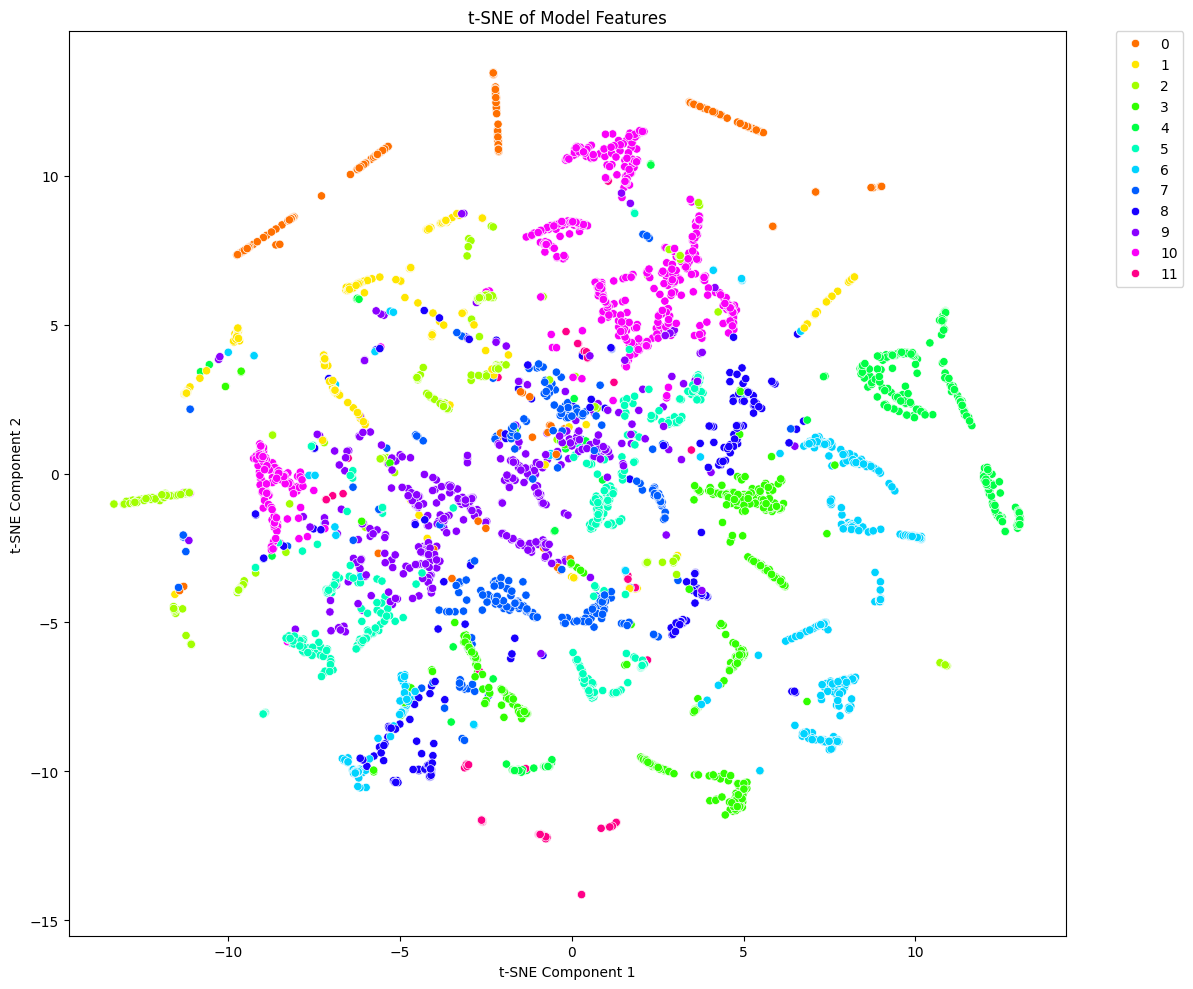

In [ ]:
# 2. 모델 적용 후 (특징) t-SNE
print("Running t-SNE on model features...")
model.eval()
with torch.no_grad():
    test_data_tensor = torch.FloatTensor(X_tsne).to(device)
    test_data_tensor = test_data_tensor.permute(0, 2, 1)
    features = model.get_features(test_data_tensor).cpu().numpy()

tsne_features = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300).fit_transform(features)

plt.figure(figsize=(12, 10))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=y_tsne, palette=sns.color_palette("hsv", len(LABELS)), legend='full')
plt.title('t-SNE of Model Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()